In [1]:
import os
from pylab import mpl
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei'] 

In [3]:
import os
from glob import glob
import numpy as np
from sklearn.model_selection import train_test_split

def get_train_file_names(_type):
    train_dir = r'..\data\train'
    train_file_names = os.path.join(train_dir, '%s.*.jpg'%_type)
    return glob(train_file_names)
def get_test_file_names():
    test_dir = r'..\data\test'
    test_file_names = os.path.join(test_dir, '*.jpg')
    return glob(test_file_names)

train_cat_file_names = get_train_file_names('cat')
train_dog_file_names = get_train_file_names('dog')
X_test_filenames = get_test_file_names()
X_train_filenames = train_cat_file_names + train_dog_file_names
y_train = np.ones((len(X_train_filenames),1))
y_train[:len(train_cat_file_names)] = 0
X_train_filenames, X_val_filenames, y_train, y_val = train_test_split(X_train_filenames,y_train,test_size=0.2,random_state=3)

print(len(X_train_filenames), X_train_filenames[:5])
print(len(X_val_filenames), X_val_filenames[:5])
print(len(y_train), y_train[:5])
print(len(y_val), y_val[:5])

19931 ['..\\data\\train\\cat.3844.jpg', '..\\data\\train\\cat.4269.jpg', '..\\data\\train\\dog.7640.jpg', '..\\data\\train\\dog.12364.jpg', '..\\data\\train\\dog.1312.jpg']
4983 ['..\\data\\train\\dog.4996.jpg', '..\\data\\train\\cat.9475.jpg', '..\\data\\train\\dog.11824.jpg', '..\\data\\train\\dog.11751.jpg', '..\\data\\train\\dog.9073.jpg']
19931 [[0.]
 [0.]
 [1.]
 [1.]
 [1.]]
4983 [[1.]
 [0.]
 [1.]
 [1.]
 [1.]]


In [12]:
# fdf5文件读取数据
import h5py
import numpy as np
from sklearn.model_selection import train_test_split

with h5py.File("preprocess.hdf5", "a") as f:
    X_train_cat_InceptionV3 = np.array(f['X_train_cat_InceptionV3'])
    X_train_cat_Xception = np.array(f['X_train_cat_Xception'])
    X_train_cat_ResNet50 = np.array(f['X_train_cat_ResNet50'])
    X_train_cat_VGG16 = np.array(f['X_train_cat_VGG16'])
    
    X_train_dog_InceptionV3 = np.array(f['X_train_dog_InceptionV3'])
    X_train_dog_Xception = np.array(f['X_train_dog_Xception'])
    X_train_dog_ResNet50 = np.array(f['X_train_dog_ResNet50'])
    X_train_dog_VGG16 = np.array(f['X_train_dog_VGG16'])
    
    X_test_InceptionV3 = np.array(f['X_test_InceptionV3'])
    X_test_Xception = np.array(f['X_test_Xception'])
    X_test_ResNet50 = np.array(f['X_test_ResNet50'])
    X_test_VGG16 = np.array(f['X_test_VGG16'])

X_train_cat = np.concatenate([X_train_cat_InceptionV3,
                              X_train_cat_Xception,
                              X_train_cat_ResNet50, 
                              X_train_cat_VGG16], axis=1)
X_train_dog = np.concatenate([X_train_dog_InceptionV3,
                              X_train_dog_Xception,
                              X_train_dog_ResNet50, 
                              X_train_dog_VGG16], axis=1)


X_train = np.vstack([X_train_cat,X_train_dog])
y_train = np.ones((len(X_train), 1))
y_train[:len(X_train_cat)] = 0
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=3)
X_test = np.concatenate([X_test_InceptionV3, X_test_Xception, X_test_ResNet50, X_test_VGG16], axis=1)

print('X_train', X_train.shape)
print('X_val', X_val.shape)
print('X_test', X_test.shape)
print('y_train', y_train.shape)
print('y_val', y_val.shape)

X_train (19931, 6656)
X_val (4983, 6656)
X_test (12500, 6656)
y_train (19931, 1)
y_val (4983, 1)


In [37]:
from keras.models import Model,Input
from keras.layers import Dropout, Dense
input_tensor = Input((X_train.shape[1],))
x = input_tensor
x = Dropout(0.5)(x)
# x = Dense(100,activation='tanh')(x)
# x = Dropout(0.5)(x)
x = Dense(1,activation='sigmoid')(x)
classification_model = Model(input_tensor,x)
classification_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
classification_model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 6656)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 6657      
Total params: 6,657
Trainable params: 6,657
Non-trainable params: 0
_________________________________________________________________


In [6]:
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
def weights_path():
    saved_models = 'saved_models'
    if not os.path.isdir(saved_models):
        os.mkdir(saved_models)
    return os.path.join(saved_models, 'best_weights.hdf5')

check_pointer = ModelCheckpoint(filepath=weights_path(),
                                verbose=1, save_best_only=True)

if 0:
    epochs = 200
    his = classification_model.fit(X_train, y_train,
                             batch_size=10000,
                             validation_data=(X_val, y_val),
                             epochs=epochs,
                             callbacks=[check_pointer], verbose=0)

print('训练完成')

W1026 16:47:38.960997 11964 deprecation_wrapper.py:119] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.




Epoch 00001: val_loss improved from inf to 0.55716, saving model to saved_models\best_weights.hdf5

Epoch 00002: val_loss improved from 0.55716 to 0.35028, saving model to saved_models\best_weights.hdf5

Epoch 00003: val_loss improved from 0.35028 to 0.20542, saving model to saved_models\best_weights.hdf5

Epoch 00004: val_loss improved from 0.20542 to 0.16304, saving model to saved_models\best_weights.hdf5

Epoch 00005: val_loss improved from 0.16304 to 0.13746, saving model to saved_models\best_weights.hdf5

Epoch 00006: val_loss improved from 0.13746 to 0.11811, saving model to saved_models\best_weights.hdf5

Epoch 00007: val_loss improved from 0.11811 to 0.10268, saving model to saved_models\best_weights.hdf5

Epoch 00008: val_loss improved from 0.10268 to 0.09046, saving model to saved_models\best_weights.hdf5

Epoch 00009: val_loss improved from 0.09046 to 0.08056, saving model to saved_models\best_weights.hdf5

Epoch 00010: val_loss improved from 0.08056 to 0.07210, saving mode


Epoch 00108: val_loss did not improve from 0.00500

Epoch 00109: val_loss improved from 0.00500 to 0.00495, saving model to saved_models\best_weights.hdf5

Epoch 00110: val_loss did not improve from 0.00495

Epoch 00111: val_loss did not improve from 0.00495

Epoch 00112: val_loss improved from 0.00495 to 0.00485, saving model to saved_models\best_weights.hdf5

Epoch 00113: val_loss did not improve from 0.00485

Epoch 00114: val_loss did not improve from 0.00485

Epoch 00115: val_loss did not improve from 0.00485

Epoch 00116: val_loss did not improve from 0.00485

Epoch 00117: val_loss did not improve from 0.00485

Epoch 00118: val_loss improved from 0.00485 to 0.00479, saving model to saved_models\best_weights.hdf5

Epoch 00119: val_loss did not improve from 0.00479

Epoch 00120: val_loss did not improve from 0.00479

Epoch 00121: val_loss did not improve from 0.00479

Epoch 00122: val_loss did not improve from 0.00479

Epoch 00123: val_loss did not improve from 0.00479

Epoch 00124

In [38]:
classification_model.load_weights(weights_path())
print('评估训练集',classification_model.evaluate(X_train,y_train))
print('评估验证集',classification_model.evaluate(X_val,y_val))

19931/19931 [==============================] - 1s 52us/step
评估训练集 [0.0013724130136961426, 0.9998996257781982]
4983/4983 [==============================] - 0s 53us/step
评估验证集 [0.004534498820055047, 0.9981938600540161]


In [41]:
import shutil
import os

def show_err(x,y,dir_name):
    predicts = classification_model.predict(x)
    for i in range(len(y)):
        if(abs(predicts[i]-y[i]) > 0.5):
            print(i, X_train_filenames[i],predicts[i])
            filename = X_train_filenames[i]
            save_dir=os.path.join(r'..\data',dir_name)
            if not os.path.isdir(save_dir):
                os.mkdir(save_dir)
            shutil.copyfile(filename,os.path.join(save_dir,os.path.split(filename)[1]))
print('预测错误的训练集数据')
show_err(X_train,y_train,'err_train')
print('预测错误的验证集数据')
show_err(X_val,y_val,'err_val')
print('完成')

预测错误的训练集数据
396 ..\data\train\dog.2542.jpg [0.48713544]
3376 ..\data\train\dog.5529.jpg [0.28952563]
预测错误的验证集数据
968 ..\data\train\cat.5875.jpg [0.4060524]
1417 ..\data\train\dog.6995.jpg [0.8123572]
2119 ..\data\train\cat.10771.jpg [0.4145571]
2199 ..\data\train\cat.1616.jpg [0.11535448]
2973 ..\data\train\cat.7937.jpg [0.79738194]
4461 ..\data\train\cat.5336.jpg [0.0558455]
4506 ..\data\train\dog.8597.jpg [0.42714232]
4532 ..\data\train\cat.2733.jpg [0.39417487]
4536 ..\data\train\cat.8112.jpg [0.9122907]
完成


In [39]:
import pandas as pd
y_pred = classification_model.predict(X_test)
y_pred = y_pred.clip(min=0.005, max=0.995)
ids = np.expand_dims(np.array(range(1,len(y_pred)+1)),axis=1)
pd_data = np.concatenate([ids, y_pred], axis=1)
df = pd.DataFrame(pd_data,columns=['id','label'])
df['id'] = df['id'].astype(np.int32)
df.to_csv('pred.csv',index=False)
print('保存测试集预测结果完成')

保存测试集预测结果完成


In [19]:
# 测试单一模型下logloss效果
X_train_InceptionV3 = np.vstack([X_train_cat_InceptionV3, X_train_dog_InceptionV3])
X_train_Xception = np.vstack([X_train_cat_Xception, X_train_dog_Xception])
X_train_ResNet50 = np.vstack([X_train_cat_ResNet50, X_train_dog_ResNet50])
X_train_VGG16 = np.vstack([X_train_cat_VGG16, X_train_dog_VGG16])
X_train_all = np.vstack([X_train_cat,X_train_dog])
y_train_all = np.ones((len(X_train_InceptionV3), 1))
y_train_all[:len(X_train_cat)] = 0

X_train_InceptionV3, X_val_InceptionV3, y_train, y_val = train_test_split(X_train_InceptionV3, y_train_all,
                                                                          test_size=0.2, random_state=3)
X_train_Xception, X_val_Xception, y_train, y_val = train_test_split(X_train_Xception, y_train_all,
                                                                    test_size=0.2, random_state=3)
X_train_ResNet50, X_val_ResNet50, y_train, y_val = train_test_split(X_train_ResNet50, y_train_all,
                                                                    test_size=0.2, random_state=3)
X_train_VGG16, X_val_VGG16, y_train, y_val = train_test_split(X_train_VGG16, y_train_all,
                                                              test_size=0.2, random_state=3)

In [20]:

input_tensor = Input((X_train_InceptionV3.shape[1],))
x = input_tensor
x = Dense(1,activation='sigmoid')(x)
classification_model = Model(input_tensor,x)
classification_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
his_InceptionV3 = classification_model.fit(X_train_InceptionV3, y_train,
                                           batch_size=10000,
                                           validation_data=(X_val_InceptionV3, y_val),
                                           epochs=epochs,
                                           verbose=1)


input_tensor = Input((X_train_Xception.shape[1],))
x = input_tensor
x = Dense(1,activation='sigmoid')(x)
classification_model = Model(input_tensor,x)
classification_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
his_Xception = classification_model.fit(X_train_Xception, y_train,
                                           batch_size=10000,
                                           validation_data=(X_val_Xception, y_val),
                                           epochs=epochs,
                                           verbose=1)

input_tensor = Input((X_train_ResNet50.shape[1],))
x = input_tensor
x = Dense(1,activation='sigmoid')(x)
classification_model = Model(input_tensor,x)
classification_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
his_ResNet50 = classification_model.fit(X_train_ResNet50, y_train,
                                           batch_size=10000,
                                           validation_data=(X_val_ResNet50, y_val),
                                           epochs=epochs,
                                           verbose=1)
input_tensor = Input((X_train_VGG16.shape[1],))
x = input_tensor
x = Dense(1,activation='sigmoid')(x)
classification_model = Model(input_tensor,x)
classification_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
his_VGG16 = classification_model.fit(X_train_VGG16, y_train,
                                           batch_size=10000,
                                           validation_data=(X_val_VGG16, y_val),
                                           epochs=epochs,
                                           verbose=1)


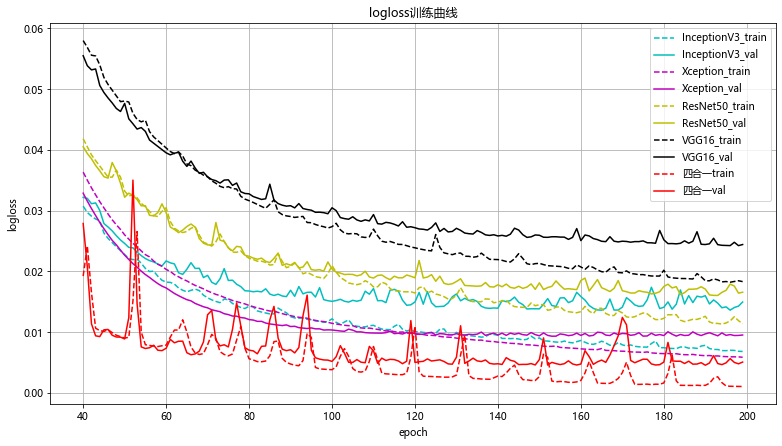

In [35]:
if 1:
    plt.figure(figsize=(13, 7))
    plt.title('logloss训练曲线')
    plt.grid(True)
    
    plt.plot(range(40,epochs), his_InceptionV3.history['loss'][40:],'c--',label='InceptionV3_train')
    plt.plot(range(40,epochs), his_InceptionV3.history['val_loss'][40:],'c',label='InceptionV3_val')
    plt.plot(range(40,epochs), his_Xception.history['loss'][40:],'m--',label='Xception_train')
    plt.plot(range(40,epochs), his_Xception.history['val_loss'][40:],'m',label='Xception_val')
    plt.plot(range(40,epochs), his_ResNet50.history['loss'][40:],'y--',label='ResNet50_train')
    plt.plot(range(40,epochs), his_ResNet50.history['val_loss'][40:],'y',label='ResNet50_val')
    plt.plot(range(40,epochs), his_VGG16.history['loss'][40:],'k--',label='VGG16_train')
    plt.plot(range(40,epochs), his_VGG16.history['val_loss'][40:],'k',label='VGG16_val')
    
    plt.plot(range(40,epochs), his.history['loss'][40:],'r--',label='四合一train')
    plt.plot(range(40,epochs), his.history['val_loss'][40:],'r',label='四合一val')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('logloss')
    plt.show()